Code Created by Florent Poux. 
This is part of a joint work with:
* Prof. Sander Oude Elberink, 
* Prof. Mila Koeva, 
* Prof. Ville Lehtola, 
* Prof. Nourian Pirouz, 
* Prof. Paulo Raposo.

Licence MIT, worked done with UTWENTE. Please refer to the article for the full comprehension.

Members of the [ITC UTWENTE](https://www.itc.nl/) or students enrolled in a Program can use the code with privileged IP Rights. 

*   Have fun with this notebook that you can very simply run (ctrl+Enter) !
*   Make sure to modify the paths to your dataset, either locally stored, on the CRIB, or in your Drive.
*   You are free to reuse in your own project, please use the followinf reference if so: XXX

For assistance:  [Linkedin](https://www.linkedin.com/in/florent-poux-point-cloud/), [Medium](https://medium.com/@florentpoux) or [Twitter](https://twitter.com/PouxPointCloud).

Enjoy!

# Step 3: Python Automation

# 3.1. Importing libraries

In [2]:
import numpy as np
import pandas as pd
import open3d as o3d
from shapely.geometry import Polygon

print(f"Open 3D Version: {o3d.__version__}")

Open 3D Version: 0.16.0


# 3.2. Loading 3D datasets

We define the specific paths to our dataset:

In [3]:
data_folder="../DATA/"
pc_dataset="30HZ1_18_sampled.xyz"
mesh_dataset="NL.IMBAG.Pand.0637100000139735.obj"
result_folder="../DATA/RESULTS/"

We can prepare the point cloud by first creating a Pandas DataFrame object called pcd_df, which will host the point cloud data:

In [5]:
pcd_df= pd.read_csv(data_folder+pc_dataset, delimiter=";")
print(pcd_df.columns)

Index(['X', 'Y', 'Z', 'R', 'G', 'B', 'Classification'], dtype='object')


Numpy to Open3D

In [9]:
pcd_o3d=o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np.array(pcd_df[['X','Y','Z']])))
pcd_o3d.colors=o3d.utility.Vector3dVector(np.array(pcd_df[['R','G','B']])/255)
pcd_o3d

PointCloud with 7103848 points.

Loading the Mesh dataset

In [8]:
mesh=o3d.io.read_triangle_mesh(data_folder+mesh_dataset)
mesh.paint_uniform_color([0.9,0.9,0.9])

TriangleMesh with 674 points and 488 triangles.

# 3.3. Python 3D Visualization

To vizualise in Open3D in the specific viewer, all we have to do is to pass a python list of objects to visualize. Our list is thus composed of one Open3D PointCloud, and one Open3D TriangleMesh, which gives [pcd_o3d,mesh]. Let us visualize this combination in a standalone window with:

In [ ]:
pcd_o3d.estimate_normals()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([pcd_o3d,mesh])

Coloring based on classification.
1=unclassified, 2=Ground, 6=building, 9=water, 26=rest

In [11]:
pcd_df['Classification'].unique()

array([ 2.,  1.,  9.,  6., 26.])

In [99]:
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 1] = [0.611, 0.8, 0.521]
colors[pcd_df['Classification'] == 2] = [0.8, 0.670, 0.521]
colors[pcd_df['Classification'] == 6] = [0.901, 0.419, 0.431]
colors[pcd_df['Classification'] == 9] = [0.564, 0.850, 0.913]
colors[pcd_df['Classification'] == 26] = [0.694, 0.662, 0.698]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)

# 4. 3D Python Challenges

## Challenge 1: POI Query

In [20]:
dist_POI=50
POI=mesh.get_center()

In [21]:
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

In [22]:
o3d.visualization.draw_geometries([pcd_selection,mesh])

## Challenge 2: Parcel Surface

In [47]:
o3d.visualization.draw_geometries_with_vertex_selection([pcd_selection])

[Open3D INFO] Clearing all points from selection.
[Open3D INFO] Adding point #34335 (92524.64, 451773.42, 16.09) to selection.
[Open3D INFO] Adding point #979 (92446.08, 451792.49, -3.00) to selection.
[Open3D INFO] Adding point #21544 (92454.49, 451813.17, 0.13) to selection.
[Open3D INFO] Adding point #19666 (92482.95, 451816.16, -3.97) to selection.
[Open3D INFO] Adding point #5924 (92471.29, 451819.53, -4.11) to selection.
[Open3D INFO] Adding point #21816 (92469.87, 451813.78, 0.41) to selection.
[Open3D INFO] Adding point #38008 (92526.86, 451802.96, 14.04) to selection.


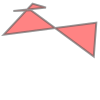

In [51]:
o3d_parcel_corners=pcd_selection.select_by_index([34335 ,979 ,21544 ,19666 ,5924 ,21816 ,38008 ])
o3d_parcel_corners=np.array(o3d_parcel_corners.points)[:,:2]
Polygon(o3d_parcel_corners)

In [52]:
pgon = Polygon(o3d_parcel_corners)
print(f"This is the obtained parcel area: {pgon.area} m²")

This is the obtained parcel area: 43.58346441077549 m²


In [53]:
def sort_coordinates(XY):
    cx, cy = XY.mean(0)
    x, y = XY.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(-angles)
    return XY[indices]

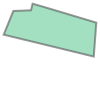

In [55]:
np_sorted_2D_corners=sort_coordinates(o3d_parcel_corners)
pgon = Polygon(np_sorted_2D_corners)
Polygon(np_sorted_2D_corners) 

In [56]:
print(f"This is the parcel area: {pgon.area} m²")

This is the parcel area: 2247.1455670795513 m²


## Challenge 3: High and Low POI

In [58]:
print(pcd_selection.get_max_bound())
print(pcd_selection.get_min_bound())

[9.25392340e+04 4.51844399e+05 2.68199997e+01]
[ 9.24402720e+04  4.51747177e+05 -4.42799997e+00]


In [59]:
np_pcd_selection=np.array(pcd_selection.points)
lowest_point_index=np.argmin(np_pcd_selection[:,2])
highest_point_index=np.argmax(np_pcd_selection[:,2])

In [62]:
low_point=pcd_selection.points[lowest_point_index]
high_point=pcd_selection.points[highest_point_index]

o3d.visualization.draw_geometries([pcd_selection])

In [75]:
lp=o3d.geometry.TriangleMesh.create_sphere()
hp=o3d.geometry.TriangleMesh.create_sphere()
lp.translate(np_pcd_selection[lowest_point_index])
hp.translate(np_pcd_selection[highest_point_index])

TriangleMesh with 762 points and 1520 triangles.

In [79]:
lp.compute_vertex_normals()
lp.paint_uniform_color([0.8,0.1,0.1])
hp.compute_vertex_normals()
hp.paint_uniform_color([0.1,0.1,0.8])
o3d.visualization.draw_geometries([pcd_selection,lp,hp])

## Point Cloud Voxelization

Adapting the coloring scheme: RGB

In [98]:
pcd_o3d.colors=o3d.utility.Vector3dVector(np.array(pcd_df[['R','G','B']])/255)
pcd_selection=pcd_o3d.select_by_index(idx)
dist_POI=50
POI=mesh.get_center()
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

TypeError: select_by_index(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.geometry.PointCloud, indices: List[int], invert: bool = False) -> open3d.cpu.pybind.geometry.PointCloud

Invoked with: PointCloud with 7103848 points., 5801

Createing the voxel grid and visualizing

In [81]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=2)
o3d.visualization.draw_geometries([voxel_grid])

Adapting the colouring scheme: Black and Red, and the selection with another POI if needed.

In [82]:
colors=np.zeros((len(pcd_df), 3))
colors[pcd_df['Classification'] == 6] = [1, 0, 0]
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
dist_POI=50
POI=mesh.get_center()
pcd_tree = o3d.geometry.KDTreeFlann(pcd_o3d)
[k, idx, _] = pcd_tree.search_radius_vector_3d(POI, dist_POI)
pcd_selection=pcd_o3d.select_by_index(idx)

In [96]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd_selection, voxel_size=2)
o3d.visualization.draw_geometries([voxel_grid])

In [85]:
idx_voxels=[v.grid_index for v in voxel_grid.get_voxels()]
color_voxels=[v.color for v in voxel_grid.get_voxels()]
bounds_voxels=[np.min(idx_voxels, axis=0),np.max(idx_voxels, axis=0)]
print(bounds_voxels)

[array([0, 0, 0]), array([49, 49, 16])]


## Challenge 4: Built Coverage

In [86]:
max_voxel={}
max_color={}

In [87]:
for idx, v in enumerate(idx_voxels):
    if (v[0],v[1]) in max_voxel.keys():
        if v[2]>max_voxel[(v[0],v[1])]:
            max_voxel[(v[0],v[1])]=v[2]
            max_color[(v[0],v[1])]=color_voxels[idx]
    else:
        max_voxel[(v[0],v[1])]=v[2]
        max_color[(v[0],v[1])]=color_voxels[idx]

In [88]:
count_building_coverage,count_non_building=0,0
for col in list(max_color.values()):
    if np.all(col==0):
        count_non_building+=1
    else:
        count_building_coverage+=1

In [94]:
print(f"Coverage of Buildings: {count_building_coverage*4} m²")   
print(f"Coverage of the Rest: {count_non_building*4} m²")
print(f"Built Ratio: {(count_building_coverage*4)/(count_building_coverage*4+count_non_building*4)} m²") 

Coverage of Buildings: 1352 m²
Coverage of the Rest: 6456 m²
Built Ratio: 0.17315573770491804 m²


# 5. Data Export

In [ ]:
#Exporting the selection
o3d.io.write_point_cloud(result_folder+pc_dataset.split(".")[0]+"_result_filtered_o3d.ply", pcd_selection, write_ascii=False, compressed=False, print_progress=False)

In [ ]:
#Exporting the Parcel Area
np.savetxt(result_folder+pc_dataset.split(".")[0]+"_selection.xyz", np.asarray(o3d_parcel_corners),delimiter=';', fmt='%1.9f')